# NEON

Here, we show how one would apply ISOFIT to data collected by the NEON imaging spectrometer.


## Setup

This is an excercise in executing ISOFIT on entire images collected on two dates from the NEON dataset.

Prerequisites:
- Download sample data from https://avng.jpl.nasa.gov/pub/PBrodrick/isofit/tutorials/subset_data.zip.  This dataset was prepped already from the data_prep notebook.  Place the dataset into the NEON folder in this repo and unzip it, which will create the 'data' folder which includes the 'subsets' directory.
- Have a working installation of ISOFIT, with sRTMnet installed and configured (see environment variable specification on the next line)

In [1]:
import logging
import os
from pathlib import Path
from types import SimpleNamespace

import matplotlib.pyplot as plt
import numpy as np
import scipy
from spectral.io import envi

import isofit
from isofit.utils.apply_oe import apply_oe 
from isofit.utils.surface_model import surface_model
from isofit import ray
ray.shutdown()


ISOFIT needs at minimum three pieces as input:

    1. Radiance measurements (rdn)
    2. Observation values    (obs)
    3. Location information  (loc)

This sample dataset from NEON has radiance and observation data, but no location values (more recent NEON datasets include the location file).  However, we can 'fake' the location file with sufficient accuracy for ISOFIT to run successfully.  Note that there are data available for two dates:

```
Radiance
├── 173647
│   ├── NIS01_20210403_173647_obs_ort
│   ├── NIS01_20210403_173647_obs_ort.hdr
│   ├── NIS01_20210403_173647_rdn_ort
│   └── NIS01_20210403_173647_rdn_ort.hdr
└── 174150
    ├── NIS01_20210403_174150_obs_ort
    ├── NIS01_20210403_174150_obs_ort.hdr
    ├── NIS01_20210403_174150_rdn_ort
    └── NIS01_20210403_174150_rdn_ort.hdr
```

These files have corresponding in situ data as well, and below we've encoded the locations of each, which we can use to help subset data files.


In [19]:
# Enable the ISOFIT logger
logging.getLogger().setLevel(logging.INFO)

# Find where we're running the tutorial from
home = os.path.abspath(os.getcwd())

# Path to the input NEON data
subset_dir = str(Path('~/.isofit/neon_subset').expanduser())
print(f'Data subset directory at: {subset_dir}')

# Path to write isofit output
output = str(Path('~/.isofit/neon_subset/output').expanduser())
if os.path.isdir(output) is False:
    os.mkdir(output)

if os.path.isdir(subset_dir) is False:
    os.mkdir(subset_dir)

surface_model_path = str(Path('~/.isofit/examples/20171108_Pasadena/configs/ang20171108t184227_surface.json').expanduser())
print(f'Surface model at: {surface_model_path}')
neon_id = '173647'


# Optionally set some environment variables as needed
#os.environ['EMULATOR_PATH'] = '/Users/brodrick/isofit_support/sRTMnet_v120.h5'
#os.environ['SIXS_DIR'] = '/Users/brodrick/6s/'

print(f'sRTMnet emulator path (required): {os.environ["EMULATOR_PATH"]}')
print(f'6s path (required): {os.environ["SIXS_DIR"]}')

%matplotlib inline

Data subset directory at: /Users/bgreenbe/.isofit/neon_subset
Surface model at: /Users/bgreenbe/.isofit/examples/20171108_Pasadena/configs/ang20171108t184227_surface.json
sRTMnet emulator path (required): /Users/bgreenbe/.isofit/srtmnet/sRTMnet_v120.h5
6s path (required): /Users/bgreenbe/Github/6sMultiComponentFN/Sixs


In [3]:
# Extract the image locations of each point of interest (POI)
# These are defined in the NEON report as pixel locations, so we round here to convert to indices
report = {}
report['173647'] = {           # Upp L Y  | Low R Y  | Upp L X | Low R X
    'WhiteTarp': np.round([2224.9626, 2230.9771, 316.0078, 324.9385,]).astype(int),
    'BlackTarp': np.round([2224.9626, 2231.0032, 328.0086, 333.9731,]).astype(int),
    'Veg'      : np.round([2245.0381, 2258.8103, 343.9006, 346.9423,]).astype(int),
    'RoadEW'   : np.round([2214.9905, 2216.9978, 348.9902, 373.0080,]).astype(int),
    'RoadNS'   : np.round([2205.9580, 2225.9612, 357.9536, 359.9608,]).astype(int)
}
report['174150'] = {           # Upp L Y | Low R Y | Upp L X  | Low R X
    'WhiteTarp': np.round([653.9626, 659.9771, 3143.0078, 3151.9385]).astype(int),
    'BlackTarp': np.round([653.9626, 660.0032, 3155.0086, 3160.9731]).astype(int),
    'Veg'      : np.round([674.0381, 687.8103, 3170.9006, 3173.9423]).astype(int),
    'RoadEW'   : np.round([643.9905, 645.9978, 3175.9902, 3200.0080]).astype(int),
    'RoadNS'   : np.round([634.9580, 654.9612, 3184.9536, 3186.9608]).astype(int)
}
# Converts numpy array to comma-separated string for ISOFIT
toString = lambda array: ', '.join(str(v) for v in array)

In [4]:
# Which NEON date to process - change this to process a different date
neon_id = list(report.keys())[0]

# Select the locations from the neon id -- roi == Regions of Interest
roi = report[neon_id]

#### Loc file generation

NEON doesn't distribute (?) a loc file, so let's fake one for now.  We'll do this for the full file and for the subset.

In [5]:
def getMetadata(file, remove=['fwhm', 'band names', 'wavelength', 'wavelength units']):
    """
    Retrieves the metadata from an envi header

    Parameters
    ----------
    rdn: str
        Path to the RDN header file containing metadata
    remove: list, default=['fwhm', 'band names', 'wavelength', 'wavelength units']
        Removes keys from the metadata dictionary
    """
    rdn_ds   = envi.open(file)
    metadata = rdn_ds.metadata.copy()
    for key in remove:
        if key in metadata:
            del metadata[key]
        else:
            print(f'Key {key!r} not found in the metadata, skipping')

    return metadata

def fakeLOC(rdn, lon, lat, elv, output=None, **kwargs):
    """
    Creates a fake LOC file

    Parameters
    ----------
    rdn: str
        Path to the RDN header file containing metadata
    lon: float
        Longitude value for location
    lat: float
        Latitude value for location
    elv: float
        Elevation in kilometers
    output: str, default=None
        Path to write the LOC file to. If None, will attempt to replace the
        substring 'rdn' in the `rdn` path with `loc`
    **kwargs
        Additional arguments passed to getMetadata()
    """
    if not output:
        if 'rdn' in rdn:
            output = rdn.replace('rdn', 'loc')
        else:
            Logger.error('No ouput file specified and cannot generate a unique name')
            return False

    metadata = getMetadata(rdn, **kwargs)
    metadata['bands'] = 3

    ds  = envi.create_image(output, metadata, ext='', force=True)
    loc = ds.open_memmap(interleave='bip', writable=True)

    loc[..., 0] = lon
    loc[..., 1] = lat
    loc[..., 2] = elv

    del ds, loc

def fakeOBS(rdn, param0=0, sea=0, sez=0, soa=0, soz=0, phase=0, slope=0, aspect=0, cosi=0, param9=0, param10=0, output=None, **kwargs):
    """
    Creates a fake OBS file

    Parameters
    ----------
    rdn: str
        Path to the RDN file containing metadata
    param0: int, float, default=0
        Parameter 0
    sea: int, float, default=0
        Solar Azimuth
    sez: int, float, default=0
        Sensor Zenith
    soa: int, float, default=0
        Solar Azimuth
    soz: int, float, default=0
        Solar Zenith
    phase: int, float, default=0
        Phase
    slope: int, float, default=0
        Slope
    aspect: int, float, default=0
        Aspect
    cosi: int, float, default=0
        COS(i)
    param9: int, float, default=0
        Parameter 9
    param10: int, float, default=0
        Parameter 10
    output: str, default=None
        Path to write the OBS file to. If None, will attempt to replace the
        substring 'rdn' in the `rdn` path with `obs`
    **kwargs
        Additional arguments passed to getMetadata()
    """
    if not output:
        if 'rdn' in rdn:
            output = rdn.replace('rdn', 'loc')
        else:
            print('No ouput file specified and cannot generate a unique name')
            return False

    rdn_ds   = envi.open(rdn)
    metadata = getMetadata(rdn, **kwargs)
    metadata['bands'] = 11

    ds  = envi.create_image(output, metadata, ext='', force=True)
    obs = ds.open_memmap(interleave='bip', writable=True)

    obs[...,  0] = param0
    obs[...,  1] = sea
    obs[...,  2] = sez
    obs[...,  3] = soa
    obs[...,  4] = soz
    obs[...,  5] = phase
    obs[...,  6] = slope
    obs[...,  7] = aspect
    obs[...,  8] = cosi
    obs[...,  9] = param9
    obs[..., 10] = param10

    del ds, obs


In [6]:
fakeLOC(
    rdn = os.path.join(subset_dir, f'NIS01_20210403_{neon_id}_rdn_ort.hdr'),
    lon = -105.237000,
    lat = 40.125000,
    elv = 1689.0
)

Key 'band names' not found in the metadata, skipping


## Apply OE

The next part walks through running the ISOFIT utility script `isofit/utils/apply_oe.py`. This is the first step of executing ISOFIT and will generate a default configuration.

In [7]:
output_surface_file = str(Path('~/.isofit/examples/20171108_Pasadena/configs/surface.mat').expanduser())
surface_model(**{
    'config_path': surface_model_path,
    'output_path': output_surface_file,
    'wavelength_path': os.path.join(subset_dir,f'NIS01_20210403_{neon_id}_rdn_ort.hdr')
})

0 ['/Users/bgreenbe/.isofit/data/reflectance/surface_model_ucsb']
1 ['/Users/bgreenbe/.isofit/data/reflectance/surface_model_ucsb']
2 ['/Users/bgreenbe/.isofit/data/reflectance/surface_model_ucsb']
3 ['/Users/bgreenbe/.isofit/data/reflectance/surface_model_ucsb']
4 ['/Users/bgreenbe/.isofit/data/reflectance/surface_model_ucsb']
5 ['/Users/bgreenbe/.isofit/data/reflectance/surface_model_ucsb']
6 ['/Users/bgreenbe/.isofit/data/reflectance/surface_model_ucsb']
7 ['/Users/bgreenbe/.isofit/data/reflectance/surface_model_ucsb']


In [9]:
kwargs = {
        'input_radiance': os.path.join(subset_dir,f'NIS01_20210403_{neon_id}_rdn_ort'), # Radiance
        'input_loc': os.path.join(subset_dir,f'NIS01_20210403_{neon_id}_loc_ort'), # Location
        'input_obs': os.path.join(subset_dir,f'NIS01_20210403_{neon_id}_obs_ort'), # Observations
        'working_directory': os.path.join(output, f'NIS01_20210403_{neon_id}'), # Output directory
        'sensor': 'neon', 
        "surface_path": output_surface_file, # Surface priors - often changes
        'emulator_base': os.environ['EMULATOR_PATH'],
        'n_cores': 4,
        "wavelength_path": None,
        "surface_category": "multicomponent_surface",
        "rdn_factors_path": None, # RCC update used 'on the fly'
        "channelized_uncertainty_path": None, # Channelized uncertainty - if you have an instrument model
        "model_discrepancy_path": None, # Model discrepancy term - handle things like unknown radiative transfer model effects
        "lut_config_file": None,
        "logging_level": "INFO",
        "log_file": None,
        "presolve": True, # Attempts to solve for the right wv range
        "analytical_line": True, # mathematical representation of OE given that the atmsophere is known
        "ray_temp_dir": "/tmp/ray",
        "segmentation_size": 10,
        "num_neighbors": [5],
        "atm_sigma": [0.5],
        "pressure_elevation": False,
}

apply_oe(**kwargs)

INFO:2025-07-08,15:20:08 || apply_oe.py:apply_oe() | Checking input data files...
INFO:2025-07-08,15:20:08 || apply_oe.py:apply_oe() | ...Data file checks complete
INFO:2025-07-08,15:20:08 || apply_oe.py:apply_oe() | Setting up files and directories....
INFO:2025-07-08,15:20:08 || template_construction.py:__init__() | Flightline ID: NIS01_20210403_173647
INFO:2025-07-08,15:20:08 || template_construction.py:__init__() | no noise path found, proceeding without
INFO:2025-07-08,15:20:08 || template_construction.py:stage_files() | Staging /Users/bgreenbe/.isofit/examples/20171108_Pasadena/configs/surface.mat to /Users/bgreenbe/.isofit/neon_subset/output/NIS01_20210403_173647/data/surface.mat
INFO:2025-07-08,15:20:08 || apply_oe.py:apply_oe() | ...file/directory setup complete
INFO:2025-07-08,15:20:08 || apply_oe.py:apply_oe() | Using inversion windows: [[350.0, 1360.0], [1410, 1800.0], [1970.0, 2500.0]]
INFO:2025-07-08,15:20:08 || apply_oe.py:apply_oe() | No wavelength file provided. Obtain

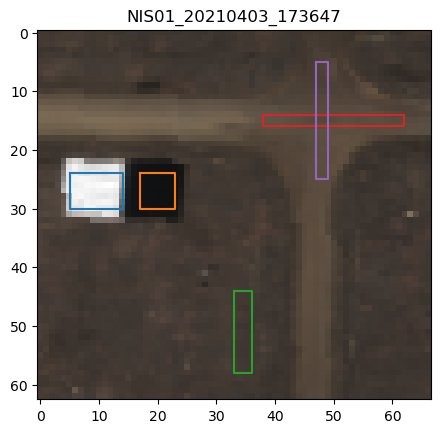

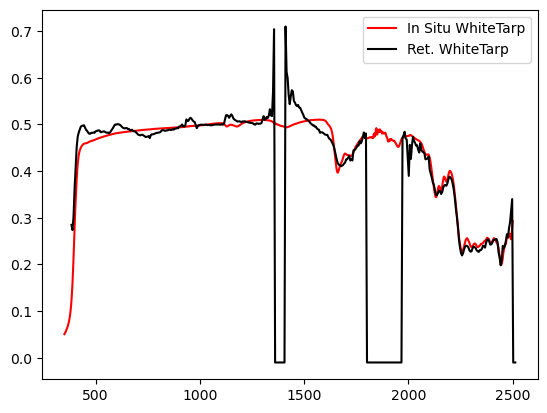

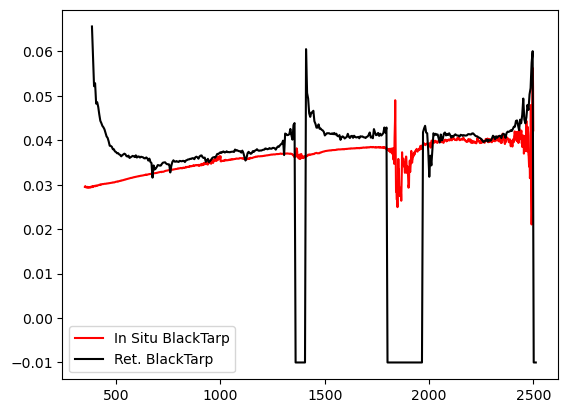

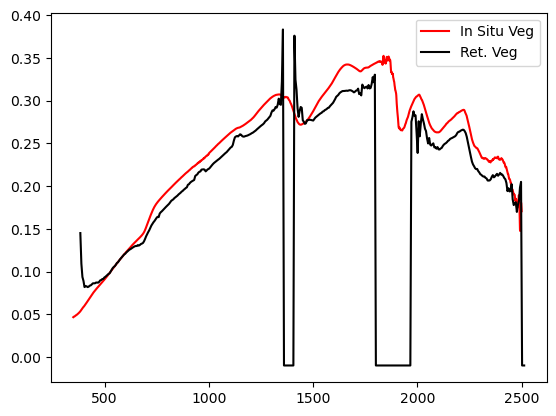

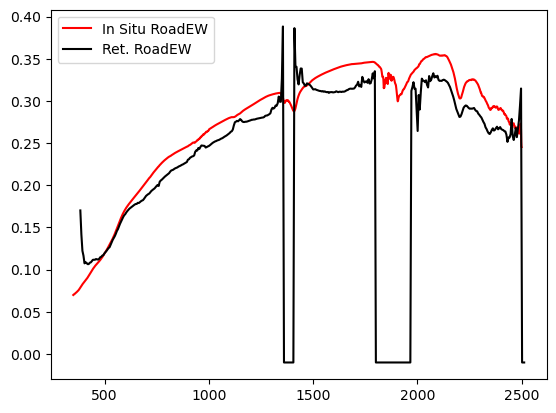

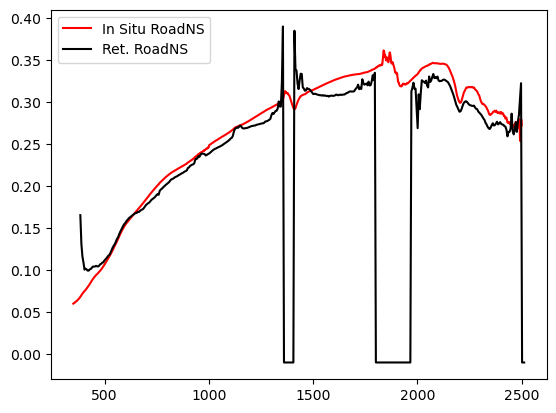

In [15]:
from spectral.io import envi
import matplotlib.pyplot as plt
for _key, key in enumerate(report.keys()):
  if _key < 1:

    rfl_ds = envi.open(os.path.join(output, f'NIS01_20210403_{key}','output',f'NIS01_20210403_{key}_rfl.hdr'))
    rfl_rgb = rfl_ds.open_memmap(interleave='bip')[:,:,np.array([60,40,30])].copy()
    wl = np.array([float(x) for x in rfl_ds.metadata['wavelength']])

    miny = np.min([np.min([i[0],i[1]]) for k,i in report[key].items()])-5
    maxy = np.max([np.max([i[0],i[1]]) for k,i in report[key].items()])+5
    minx = np.min([np.min([i[2],i[3]]) for k,i in report[key].items()])-5
    maxx = np.max([np.max([i[2],i[3]]) for k,i in report[key].items()])+5

    plt.figure()
    plt.imshow(rfl_rgb / np.max(rfl_rgb,axis=(0,1)))
    plt.title(f'NIS01_20210403_{key}')
    for k,i in report[key].items():
        plt.plot([i[2]-minx,i[3]-minx,i[3]-minx,i[2]-minx,i[2]-minx],[i[0]-miny,i[0]-miny,i[1]-miny,i[1]-miny,i[0]-miny],label=k)

    for k,i in report[key].items():
        plt.figure()
        in_situ_path = str(Path(f'~/.isofit/neon_subset/FieldSpectrometer/{k}01/Data/{k}01_Refl.dat').expanduser())
        in_situ = np.genfromtxt(in_situ_path, skip_header=3)
        plt.plot(in_situ[:,0], in_situ[:,1], label=f'In Situ {k}',c='red',ls='-')
        mean_rfl = np.mean(rfl_ds.open_memmap(interleave='bip')[i[0]-miny:i[1]-miny,i[2]-minx:i[3]-minx,:],axis=(0,1))
        plt.plot(wl, mean_rfl, label=f'Ret. {k}', c='black')
        plt.legend()


## Per-Pixel Retrievals

This next section is an excercise in running ISOFIT in pixel mode (dynamically from python).

To get started with executing ISOFIT for iterable improvements, ISOFIT is comprised of three primary pieces:

1. The `ForwardModel` object
2. The `IO` object
2. The `Inverse` object

There is also an `Isofit` object that holds each of the other three, and is commonly used for more generic runs (it is what is called by apply_oe).

In [16]:
from isofit.core.isofit import Isofit
from isofit.core.fileio import IO
from isofit.core.forward import ForwardModel
from isofit.inversion.inverse import Inversion
from isofit.inversion.inverse_simple import invert_algebraic
from isofit.configs import configs
from isofit.core.geometry import Geometry

import os
import logging
import numpy as np
from spectral.io import envi
import matplotlib.pyplot as plt
%matplotlib inline

# Enable the ISOFIT logger
logging.getLogger().setLevel(logging.INFO)

In [22]:
# Now run actual retrievals
config = configs.create_new_config(os.path.join(output, f'NIS01_20210403_{neon_id}','config',f'NIS01_20210403_{neon_id}_isofit.json')) 
config.forward_model.surface.surface_file = str(Path('~/.isofit/examples/20171108_Pasadena/configs/surface.mat').expanduser())

#model = Isofit(os.path.join(output,f'NIS01_20210403_{neon_id}','config',f'NIS01_20210403_{neon_id}_isofit.json'))
config.input.measured_radiance_file =  os.path.join(subset_dir, f'NIS01_20210403_{neon_id}_rdn_ort')
config.input.obs_file =  os.path.join(subset_dir, f'NIS01_20210403_{neon_id}_obs_ort')
config.input.loc_file =  os.path.join(subset_dir, f'NIS01_20210403_{neon_id}_loc_ort')

fm = ForwardModel(config)
io = IO(config, fm)
inv = Inversion(config, fm)

INFO:2025-07-08,15:50:17 || configs.py:create_new_config() | Loading config file: /Users/bgreenbe/.isofit/neon_subset/output/NIS01_20210403_173647/config/NIS01_20210403_173647_isofit.json
INFO:2025-07-08,15:50:17 || radiative_transfer_engine.py:__init__() | Loading from wavelength_file: /Users/bgreenbe/.isofit/neon_subset/output/NIS01_20210403_173647/data/wavelengths.txt
INFO:2025-07-08,15:50:17 || radiative_transfer_engine.py:__init__() | Prebuilt LUT provided
INFO:2025-07-08,15:50:17 || luts.py:load() | Loading LUT into memory
INFO:2025-07-08,15:50:17 || radiative_transfer_engine.py:__init__() | LUT grid loaded from file


In [24]:
region = 'Veg'
offsets = {}
miny = np.min([np.min([i[0],i[1]]) for k,i in report[neon_id].items()])-5
maxy = np.max([np.max([i[0],i[1]]) for k,i in report[neon_id].items()])+5
minx = np.min([np.min([i[2],i[3]]) for k,i in report[neon_id].items()])-5
maxx = np.max([np.max([i[2],i[3]]) for k,i in report[neon_id].items()])+5
offsets[neon_id] = [minx,miny]
adj_roi = [roi[region][0] - offsets[neon_id][1], roi[region][1] - offsets[neon_id][1], roi[region][2] - offsets[neon_id][0], roi[region][3] - offsets[neon_id][0]]

rdn = np.mean(envi.open(config.input.measured_radiance_file + '.hdr').open_memmap(interleave='bip')[adj_roi[0]:adj_roi[1],adj_roi[2]:adj_roi[3],:].copy(),axis=(0,1))
obs = np.mean(envi.open(config.input.obs_file + '.hdr').open_memmap(interleave='bip')[adj_roi[0]:adj_roi[1],adj_roi[2]:adj_roi[3],:].copy(),axis=(0,1))
loc = np.mean(envi.open(config.input.loc_file + '.hdr').open_memmap(interleave='bip')[adj_roi[0]:adj_roi[1],adj_roi[2]:adj_roi[3],:].copy(),axis=(0,1))

geom = Geometry(obs=obs,loc=loc)
states = inv.invert(rdn, geom)

x_surface, x_RT, x_instrument = fm.unpack(states[-1,:])

x_alg, coeffs = invert_algebraic(fm.surface, fm.RT, fm.instrument, 
                           x_surface, x_RT, x_instrument,
                           rdn, geom,
                           )


(13, 428)
[0.10742364 0.60519719]


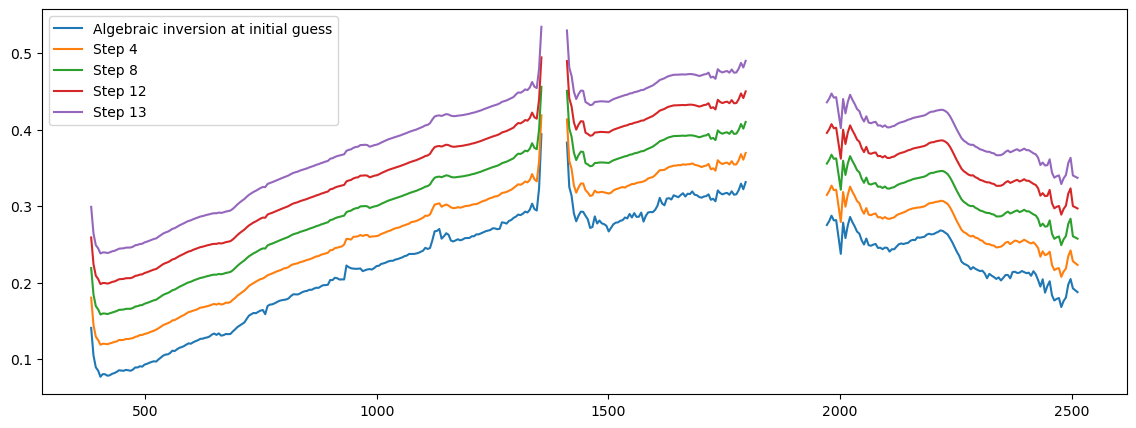

In [25]:
def closest_wl(mv):
    return np.argmin(np.abs(io.meas_wl-mv))

wl_nan = io.meas_wl.copy()
wl_nan[closest_wl(1360):closest_wl(1410)] = np.nan
wl_nan[closest_wl(1800):closest_wl(1970)] = np.nan

fig = plt.figure(figsize=(14,5))
print(states.shape)
offset = 0
for n in range(0,states.shape[0],4):
    lab = f'Step {n}'
    if n == 0:
        lab = 'Algebraic inversion at initial guess'
    
    plt.plot(wl_nan, states[n,:-2] + offset, label=lab)
    offset += 0.04
plt.plot(wl_nan, states[-1,:-2] + offset, label=f'Step {states.shape[0]}')
plt.legend()

print(states[-1,-2:])